# 1. 基础设置

In [1]:
# 导包
import torch
import os
import argparse
import pandas as pd
import tqdm
import numpy as np
# os.environ['NUMEXPR_MAX_THREADS'] = '48'

# 导入各个指标
import sys
sys.path.append('/home/dengruijun/data/FinTech/PP-Split/')
from ppsplit.quantification.distance_correlation.distCor import distCorMetric
from ppsplit.quantification.fisher_information.dFIL_inverse import dFILInverseMetric
from ppsplit.quantification.shannon_information.mutual_information import MuInfoMetric
from ppsplit.quantification.shannon_information.ULoss import ULossMetric
from ppsplit.quantification.rep_reading.rep_reader import PCA_Reader
from ppsplit.quantification.shannon_information.ITE_tools import Shannon_quantity

from target_model.task_select import get_dataloader_and_model,get_dataloader_and_model, get_dataloader,get_models

# utils
from ppsplit.utils.utils import create_dir

In [2]:
args = {
        # 'device':torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
        'device':torch.device("cpu"),
        # 'dataset':'CIFAR10',
        # 'dataset':'bank',
        # 'dataset':'credit',
        # 'dataset':'purchase',
        'dataset':'Iris',
        # 'result_dir': '20240702-FIL/',
        'result_dir': '20240702-effectiveInfo/',
        'oneData_bs': 30,
        'test_bs': 1,
        'train_bs': 1,
        'noise_scale': 0, # 防护措施
        'split_layer': 1,
        # 'test_num': 'invdFIL', # MI, invdFIL, distCor, ULoss, 
        'test_num': 'effectiveInfo1.0'
        }
print(args['device'])


cpu


In [3]:
data_msg = get_dataloader(args)
model_msg = get_models(args)
msg = {**model_msg,**data_msg}

# 数据集
one_data_loader,trainloader,testloader = data_msg['one_data_loader'],data_msg['trainloader'], data_msg['testloader']

# 模型和路径
client_net,decoder_net = model_msg['client_net'],model_msg['decoder_net']
decoder_route = model_msg['decoder_route']
image_deprocess = model_msg['image_deprocess']

results_dir = model_msg['results_dir']
inverse_dir = results_dir + 'layer'+str(args['split_layer'])+'/'
data_type = 1 if args['dataset'] == 'CIFAR10' else 0
split_layer = args['split_layer']

print('results_dir:',results_dir)
print('inverse_dir:',inverse_dir)
print('decoder_route:',decoder_route)

create_dir(results_dir)

# client_net使用
client_net = client_net.to(args['device'])
client_net.eval()

# for n, p in client_net.named_parameters():
#     print(n, p.shape)

===============processing data===============
X_train.shape: (120, 4)
X_test.shape: (30, 4)
y_train.shape: (120,)
y_test.shape: (30,) <class 'numpy.ndarray'>
===============processing data end===============


linear1.weight
linear1.bias
train decoder model...
['Tanh', ('D', 4, 128)]
results_dir: ../../results/20240702-effectiveInfo//Iris/effectiveInfo1.0/
inverse_dir: ../../results/20240702-effectiveInfo//Iris/effectiveInfo1.0/layer1/
decoder_route: ../../results/20240702-effectiveInfo//Iris/effectiveInfo1.0//Decoder-layer1.pth


IrisNet(
  (linear1): Linear(in_features=4, out_features=128, bias=True)
)

# 5. effective information

## 5.1 effect Fisher

In [5]:
# effective fisher 计算函数
import torch.autograd.functional as F
import torch
import time

# nips23
from torch.autograd.functional import jvp
import random
import math

import pandas as pd

# 自己实现的、规规矩矩的
def computing_det_with_outputs(model, inputs, outputs, sigmas): # sigma_square
        # batchsize:
        batch_size = inputs.shape[0] # 一个batch的样本数目
        output_size = outputs[0].numel() # 一个样本的outputs长度
        input_size = inputs[0].numel() # 一个样本的outputs长度
        effect_fisher_sum = 0.0

        # 遍历单个样本: 换数据
        for i in range(batch_size):
            input_i = inputs[i].unsqueeze(0)

            # 计算jacobian
            J = F.jacobian(model, input_i)
            # J = J.reshape(J.shape[0],outputs.numel(),inputs.numel()) # (batch, out_size, in_size)
            J = J.reshape(output_size, input_size) # (batch, out_size, in_size)
            # print(f"J2.shape: {J.shape}, J2.prod: {torch.prod(torch.tensor(list(J.shape)))}")
            # 计算eta
            JtJ = torch.matmul(J.t(), J)
            I = 1.0/(sigmas)*JtJ
            # ddFIL  = I.trace().div(input_size*input_size)

            # 储存I
            # I_np = I.cpu().detach().numpy()
            # df = pd.DataFrame(I_np)
            # df.to_csv(f'{i}.csv',index=False,header=False)

            # print("I: ", I)
            # w = torch.det(I)
            # print('det I: ', I.det().log())

            f1 = input_size * torch.log(2*torch.pi*torch.exp(torch.tensor(1.0)))
            f2 = torch.logdet(I)
            # print('log det I: ',f2 )
            print('f1: ',f1)
            print('f2: ',f2)
            effect_fisher = 0.5 * (f1 - f2)
            effect_fisher_sum+=effect_fisher

            print("effect_fisher: ",effect_fisher)

        # print("Jt*J: ", JtJ)
        # print("Jt*J: ", JtJ.shape, JtJ)
        # print("I.shape: ", I.shape)
        # eta = dFIL
        # print(f"eta: {eta}")
        # print('t2-t1=',t2-t1, 't3-t2', t3-t2)
        effect_fisher_mean = effect_fisher_sum / batch_size
        return effect_fisher_mean.cpu().detach().numpy()


# 用diag 来化简
def computing_diag_det_with_outputs(model, inputs, outputs, sigmas): # sigma_square
        # batchsize:
        batch_size = inputs.shape[0] # 一个batch的样本数目
        output_size = outputs[0].numel() # 一个样本的outputs长度
        input_size = inputs[0].numel() # 一个样本的outputs长度
        effect_fisher_sum = 0.0

        # avg
        I_diagonal_batch_avg = torch.zeros(input_size).to(args['device']) # batch上做平均
        print("I_diagonal_batch_avg: ",I_diagonal_batch_avg.shape)
        f2_2_avg_outer = torch.tensor(0.0).to(args['device'])
        f2_avg_outer = torch.tensor(0.0).to(args['device'])
        
        # effecti_fisher第一部分
        f1 = input_size * torch.log(2*torch.pi*torch.exp(torch.tensor(1.0)))
        # print('f1: ',f1)

        # f2需要求平均？
        # 遍历单个样本: 换数据
        for i in range(batch_size): # 对每个batch
            input_i = inputs[i].unsqueeze(0)

            # 计算jacobian
            J = F.jacobian(model, input_i)
            # J = J.reshape(J.shape[0],outputs.numel(),inputs.numel()) # (batch, out_size, in_size)
            J = J.reshape(output_size, input_size) # (batch, out_size, in_size)
            # print(f"J2.shape: {J.shape}, J2.prod: {torch.prod(torch.tensor(list(J.shape)))}")
            # 计算eta
            JtJ = torch.matmul(J.t(), J)
            I = 1.0/(sigmas)*JtJ
            # print("I: ", I)
            # diagonal fisher information matrix (approximation)
            I_diagonal = torch.diagonal(I,dim1=0,dim2=1) # vector
            # print("I_diagonal: ",I_diagonal.shape)

            I_diag = torch.diag_embed(I_diagonal) # matrix

            # batch的平均
            I_diagonal_batch_avg += I_diagonal / (batch_size)

            # 储存I
            # I_np = I.cpu().detach().numpy()
            # df = pd.DataFrame(I_np)
            # df.to_csv(f'{i}.csv',index=False,header=False)

            # print("I: ", I)
            # w = torch.det(I)
            # print('det I: ', I.det().log())

            f2 = torch.logdet(I)
            # f2_1 = torch.logdet(I_diag)
            f2_2 = torch.sum(torch.log(I_diagonal+1e-10)) # /I_diagonal.numel()

            f2_2_avg_outer += f2_2 / batch_size
            f2_avg_outer += f2 / batch_size

            # print('log det I: ',f2 )
            # print('f1: ',f1)
            print('f2: ',f2)
            # print('f2_1: ',f2_1)
            print('f2_2: ',f2_2)

        f2_2_avg_inner = torch.sum(torch.log(I_diagonal_batch_avg+1e-10))

        print('f2_2_avg_outer: ',f2_2_avg_outer)
        print('f2_2_avg_inner: ',f2_2_avg_inner)

        # effect_fisher = 0.5 * (f1 - f2_2_avg_inner)
        effect_fisher = 0.5 * (f1 - f2_2_avg_outer)
        # effect_fisher = 0.5 * (f1 - f2_avg_outer)
        # effect_fisher_sum+=effect_fisher

        # print("effect_fisher: ",effect_fisher)
        
        # effect_fisher_mean = effect_fisher_sum / batch_size
        return effect_fisher.cpu().detach().numpy()

In [6]:
# effect fisher 指标

effectFisher_same_layer_list = []
Fishermetric = dFILInverseMetric() 
# for j, data in enumerate(tqdm.tqdm(testloader)): # 对testloader遍历
for j, data in enumerate(tqdm.tqdm(one_data_loader)): # 测试第一个testloader
    images, labels = data
    print('labels: ',labels)
    images, labels = images.to(args['device']), labels.to(args['device'])
    with torch.no_grad():
        # inference
        outputs = client_net(images).clone().detach()
        # fisher
        outputs = client_net(images)
        # images = images.unsqueeze(0)
        # effectFisher = Fishermetric._computing_det_with_outputs(model=client_net, inputs=images, outputs=outputs,sigmas = 0.01)
        # effectFisher = computing_det_with_outputs(model=client_net, inputs=images, outputs=outputs,sigmas = 0.01)

        effectFisher = computing_diag_det_with_outputs(model=client_net, inputs=images, outputs=outputs,sigmas = 0.01)
        effectFisher_same_layer_list.append(effectFisher)
# print(f"Layer {split_layer} effecInfo: {sum(effecInfo_same_la yer_list)/len(effecInfo_same_layer_list)}")
print(f"effectfisher: {sum(effectFisher_same_layer_list)/len(effectFisher_same_layer_list)}")


  0%|          | 0/1 [00:00<?, ?it/s]

labels:  tensor([1, 0, 2])
I_diagonal_batch_avg:  torch.Size([4])


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

f2:  tensor(nan, device='cuda:1')
f2_2:  tensor(44.7148, device='cuda:1')
f2:  tensor(nan, device='cuda:1')
f2_2:  tensor(44.7148, device='cuda:1')
f2:  tensor(nan, device='cuda:1')
f2_2:  tensor(44.7148, device='cuda:1')
f2_2_avg_outer:  tensor(44.7148, device='cuda:1')
f2_2_avg_inner:  tensor(44.7148, device='cuda:1')
effectfisher: -16.681655883789062


## 5.2 effect Entropy

In [4]:
# effect entropy 计算函数
import math
import numpy as np
def shannon_entropy_pyent(time_series):
    """Calculate Shannon Entropy of the sample data.

    Parameters
    ----------
    time_series: np.ndarray | list[str]

    Returns
    -------
    ent: float
        The Shannon Entropy as float value
    """

    # Calculate frequency counts
    _, counts = np.unique(time_series, return_counts=True)
    total_count = len(time_series)
    # print('counts: ', counts)
    # print("total_count: ",total_count)

    # Calculate frequencies and Shannon entropy
    frequencies = counts / total_count
    # print("freq: ",frequencies)
    ent = -np.sum(frequencies * np.log(frequencies))

    return ent

# import infotopo
import ppsplit.quantification.shannon_information.infotopo as infotopo

def shannon_entropy_infotopo(x):
    information_top = infotopo.infotopo(dimension_max = x.shape[1],
                                        dimension_tot = x.shape[1],
                                        sample_size = x.shape[0],
                                        nb_of_values = 9, # 不是很懂这个意思，为什么iris对应9？
                                        )
    # 计算联合分布的概率？（全排列）
    joint_prob = information_top._compute_probability(x)
    print('joint_prob: ',joint_prob)
    # 计算联合熵（全排列的）
    joint_prob_ent = information_top.simplicial_entropies_decomposition(x) # log2
    new_joint_prob_ent = {key: value * np.log(2) for key, value in joint_prob_ent.items()} #ln 转2为底 成 e为底
    print("joint_entropy: ",new_joint_prob_ent)
    # ent = information_top._compute_forward_entropies(x)
    information_top.entropy_simplicial_lanscape(joint_prob_ent) # 画图
    # ent = _entropy(np.array(list(new_joint_prob_ent.values())))

    joint_entropy_final = list(new_joint_prob_ent.values())[-1]
    return joint_entropy_final


  0%|          | 0/1 [00:00<?, ?it/s]

effectEntro_pyent:  10.78568442565739
joint_prob:  {'0000': 0.7666666666666667, '0100': 0.06666666666666667, '0011': 0.03333333333333333, '0001': 0.1, '1100': 0.03333333333333333}
Percent of tuples processed : 0
joint_entropy:  {(4,): 1.9819572275458939, (3,): 1.7745281734898692, (2,): 1.900864205924261, (1,): 1.945733436884763, (3, 4): 2.560998380349697, (2, 4): 3.0315188853635178, (1, 4): 2.7655866155925666, (2, 3): 2.904216051704555, (1, 3): 2.470886138576437, (1, 2): 3.0777286974008473, (2, 3, 4): 3.1701483214755073, (1, 3, 4): 2.979194070987063, (1, 2, 4): 3.2625679455501664, (1, 2, 3): 3.2625679455501664, (1, 2, 3, 4): 3.354987569624826}
undersampling percent in dim  1  =  0.0
undersampling percent in dim  2  =  0.0
undersampling percent in dim  3  =  0.0
undersampling percent in dim  4  =  0.0
the undersampling dimension is  4 with self.p_value_undersampling 0.05


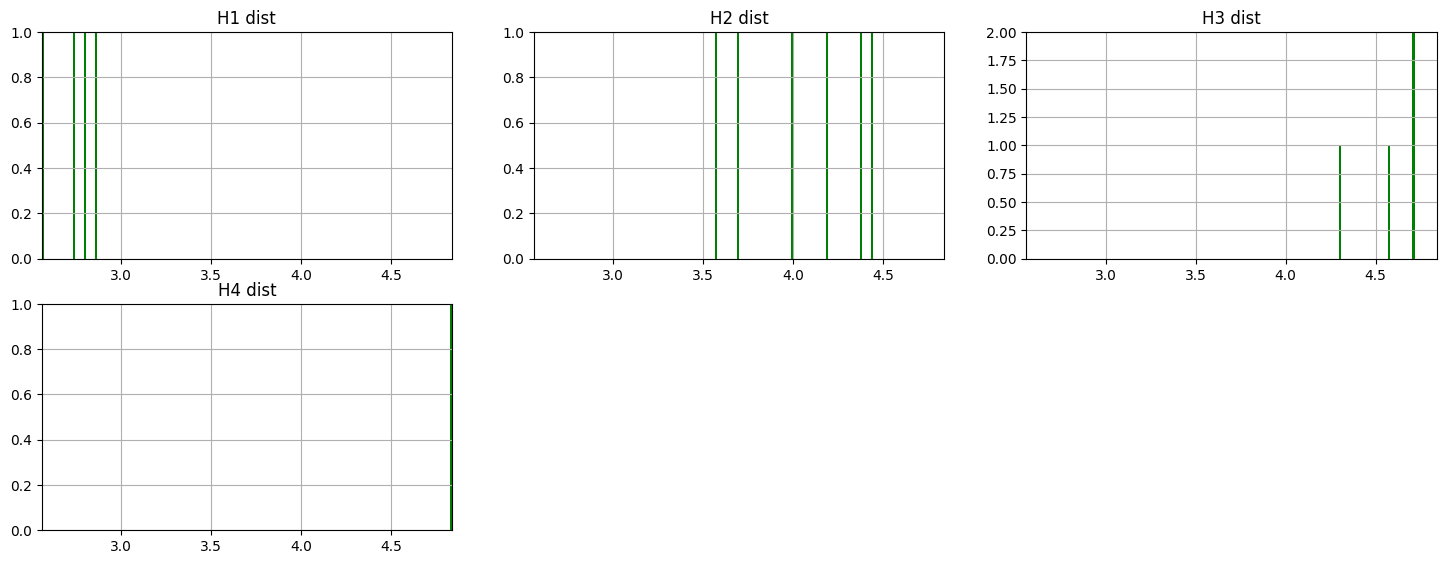

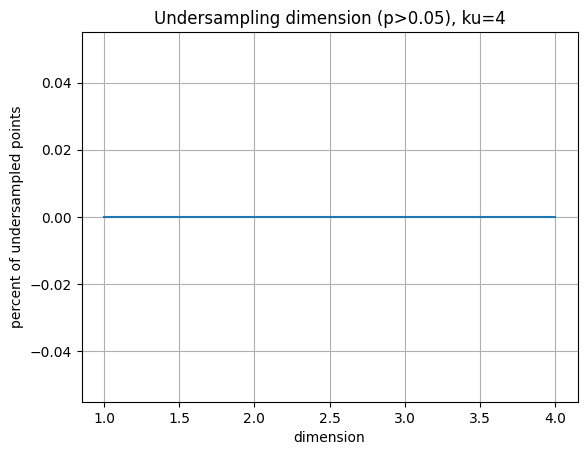

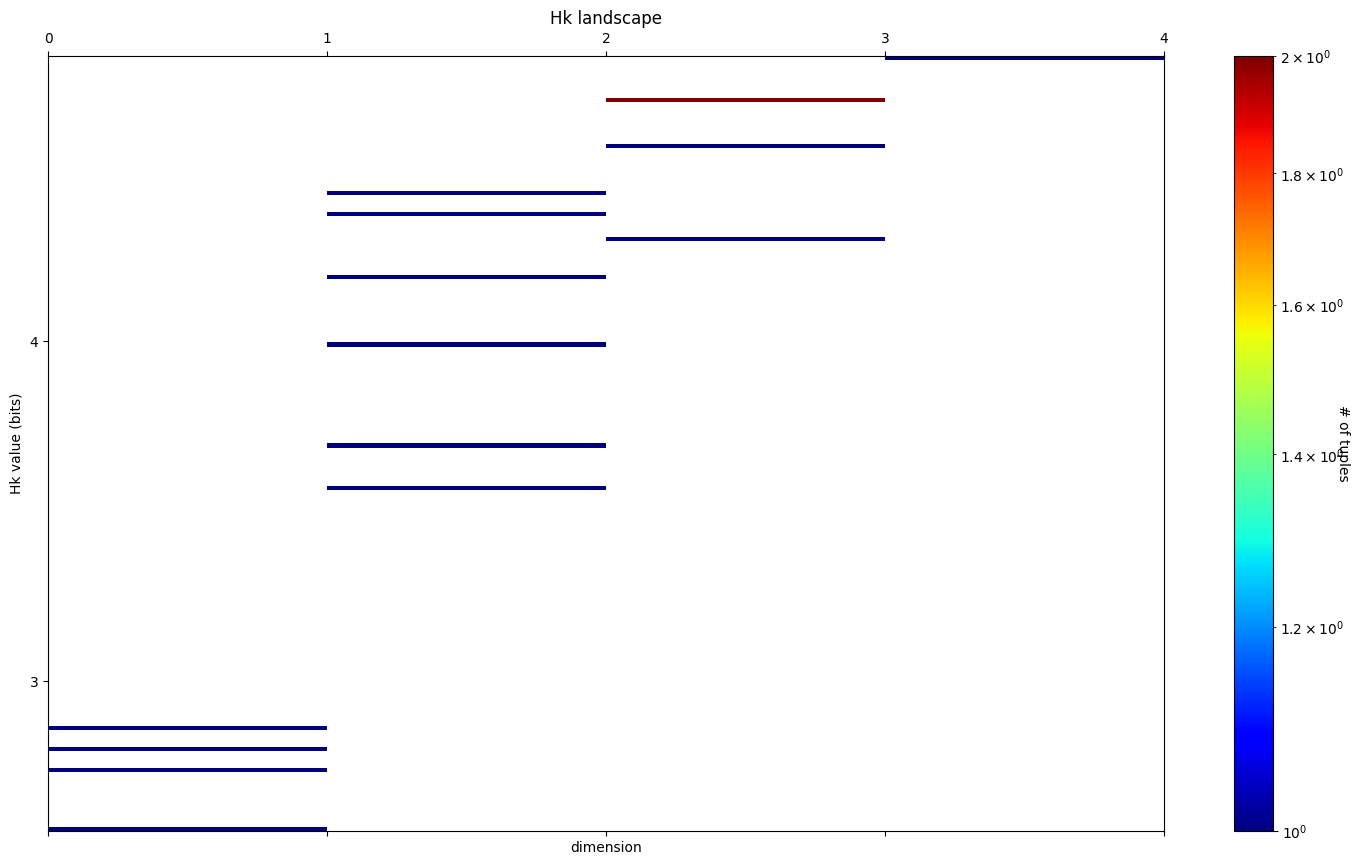

100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


In [5]:
# effective entorpy

from pyentrp import entropy as ent

for j, data in enumerate(tqdm.tqdm(one_data_loader)): # 测试第一个testloader
# for j, data in enumerate(tqdm.tqdm(testloader)): 
    images, labels = data
    images, labels = images.to(args['device']), labels.to(args['device'])
    # print(images)
    with torch.no_grad():
        # ITE
        # effectEntro = Shannon_quantity(images)
        # print("effectEntro_ite: ",effectEntro)

        # PyEntropy
        effectEntro_pyent = 0.0
        for i in range(len(images[0])): # 对每个维度
            effectEntro_pyent  += shannon_entropy_pyent(images[:,i].flatten().detach().cpu().numpy())
            # print('effectEntro_pyent: ',effectEntro_pyent)
        # effectEntro_pyent = shannon_entropy(images.flatten(start_dim=1).detach().cpu().numpy())
        print('effectEntro_pyent: ',effectEntro_pyent)

        # infotopo
        effectEntro_infotopo = shannon_entropy_infotopo(images.flatten(start_dim=1).detach().cpu().numpy())
        # print('effectEntro_infotopo: ',effectEntro_infotopo)

## 5.3 effect information

In [ ]:
effecInfo_diff_layer_list = []
effecInfo_same_layer_list = []
EntropyMetric = ULossMetric()
Fishermetric = dFILInverseMetric()

InversedFIL_same_layer_list = []
# for j, data in enumerate(tqdm.tqdm(testloader)): # 对testloader遍历
for j, data in enumerate(tqdm.tqdm(one_data_loader)): # 测试第一个testloader
    images, labels = data
    images, labels = images.to(args['device']), labels.to(args['device'])
    with torch.no_grad():
        # inference
        outputs = client_net(images).clone().detach()
        # effect entropy 
        # effecEntro= EntropyMetric._entropy_prob_batch(images) # H(x)
        effectEntro = shannon_entropy_infotopo(images.flatten(start_dim=1).detach().cpu().numpy())

        # effecit fisher
        # outputs = client_net(images)
        inverse_dFIL = Fishermetric.quantify(model=client_net, inputs=images, outputs=outputs,sigmas = 0.01, with_outputs=True)
        effectFisher = computing_det_with_outputs(model=client_net, inputs=images, outputs=outputs,sigmas = 0.01)

        # 存储
        effecInfo_same_layer_list.append(effectEntro-effectFisher)
        InversedFIL_same_layer_list.append(inverse_dFIL)

        # 打印一下
        print("effecEntro: ", effectEntro)
        print("inverse_dFIL: ",inverse_dFIL)

print(f"Layer {args['split_layer']} effecInfo: {sum(effecInfo_same_layer_list)/len(effecInfo_same_layer_list)}") # 在多个batch上再求平均，这里有点问题。
print(f"Layer {args['split_layer']} InversedFIL: {sum(InversedFIL_same_layer_list)/len(InversedFIL_same_layer_list)}")
effecInfo_diff_layer_list.append(effecInfo_same_layer_list)

# 保存到csv中
matrix = np.array(effecInfo_diff_layer_list) # 有点大，x
transpose = matrix.T # 一行一条数据，一列代表一个layer 
# pd.DataFrame(data=transpose, columns=[i for i in split_layer_list]).to_csv(results_dir + f'effecInfo-bs{batch_size}.csv',index=False)

# save_route = results_dir + f'effecInfo-120.csv'
# if os.path.exists(save_route):
#     df = pd.read_csv(save_route)
#     df[args['split_layer']] = transpose
#     df.to_csv(save_route,index=False)
# else:
#     pd.DataFrame(data=transpose, columns=[args['split_layer']]).to_csv(save_route,index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

joint_prob:  {'0000': 0.7666666666666667, '0100': 0.06666666666666667, '0011': 0.03333333333333333, '0001': 0.1, '1100': 0.03333333333333333}
Percent of tuples processed : 0
joint_entropy:  {(4,): 1.9819572275458939, (3,): 1.7745281734898692, (2,): 1.900864205924261, (1,): 1.945733436884763, (3, 4): 2.560998380349697, (2, 4): 3.0315188853635178, (1, 4): 2.7655866155925666, (2, 3): 2.904216051704555, (1, 3): 2.470886138576437, (1, 2): 3.0777286974008473, (2, 3, 4): 3.1701483214755073, (1, 3, 4): 2.979194070987063, (1, 2, 4): 3.2625679455501664, (1, 2, 3): 3.2625679455501664, (1, 2, 3, 4): 3.354987569624826}
inverse_dFIL:  2.0611473e-05
f1:  tensor(11.3515)
f2:  tensor(37.4480, device='cuda:1')
effect_fisher:  tensor(-13.0482, device='cuda:1')
f1:  tensor(11.3515)
f2:  tensor(37.4480, device='cuda:1')
effect_fisher:  tensor(-13.0482, device='cuda:1')
f1:  tensor(11.3515)
f2:  tensor(37.4480, device='cuda:1')
effect_fisher:  tensor(-13.0482, device='cuda:1')
f1:  tensor(11.3515)
f2:  tens

100%|██████████| 1/1 [00:03<00:00,  3.24s/it]

f1:  tensor(11.3515)
f2:  tensor(37.4480, device='cuda:1')
effect_fisher:  tensor(-13.0482, device='cuda:1')
f1:  tensor(11.3515)
f2:  tensor(37.4480, device='cuda:1')
effect_fisher:  tensor(-13.0482, device='cuda:1')
f1:  tensor(11.3515)
f2:  tensor(37.4480, device='cuda:1')
effect_fisher:  tensor(-13.0482, device='cuda:1')
f1:  tensor(11.3515)
f2:  tensor(37.4480, device='cuda:1')
effect_fisher:  tensor(-13.0482, device='cuda:1')


100%|██████████| 1/1 [00:03<00:00,  3.27s/it]

Layer 3 effecInfo: 16.403208204085274
Layer 3 InversedFIL: 2.0611472791642882e-05


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
scaler = MinMaxScaler(feature_range=(0, 1))
# x = next(iter(one_data_loader))
for i,_ in one_data_loader:
        # print(i)
        y = scaler.fit_transform(i)
# print(y)

In [ ]:
y = torch.rand(10,341) # 最大能接受341个特征 
z = torch.randn(100,200)
e1 = Shannon_quantity(y)
e2 = Shannon_quantity(z)
print(e1)
print(e2)
# print(np.log(0))

174.3527964782727
335.9202759013189


In [ ]:
import pandas as pd
dataPath = '/home/dengruijun/data/FinTech/DATASET/kaggle-dataset/bank/bank-additional-full.csv'

[X_train, y_train], [X_test, y_test] = preprocess_bank_dataset(dataPath)
df = pd.DataFrame(X_test)
df.describe()

===============processing data===============
X_train.shape: (32950, 63)
X_test.shape: (8238, 63)
y_train.shape: (32950, 1)
y_test.shape: (8238, 1) <class 'numpy.ndarray'>
===============processing data end===============


,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
count,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,...,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000
mean,0.289148,0.157198,0.023671,0.021850,0.063608,0.088614,0.032168,0.078174,0.064093,0.141539,...,0.284123,0.054413,0.020963,0.838213,0.081903,0.251712,0.335361,0.453437,0.089942,0.344142
std,0.453394,0.364010,0.152031,0.146202,0.244068,0.284203,0.176457,0.268462,0.244934,0.348598,...,0.171524,0.051057,0.030769,0.366935,0.121449,0.146193,0.252907,0.286649,0.055046,0.179637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.160494,0.022977,0.000000,1.000000,0.000000,0.104167,0.199532,0.192469,0.036953,0.203781
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.234568,0.040057,0.018182,1.000000,0.000000,0.333333,0.269680,0.418410,0.093403,0.425709
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.382716,0.068524,0.036364,1.000000,0.142857,0.333333,0.296960,0.719665,0.143278,0.512287
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.769622,0.272727,1.000000,1.000000,0.479167,1.000000,1.000000,0.150759,0.512287


In [7]:
# 测试diagonal
import torch
x = torch.randn(6,5)
y = torch.diagonal(x)
z = torch.diag_embed(y)
print(x)
print(y)
print(z)


tensor([[-1.4883,  1.4026, -0.9285,  1.1072,  1.5569],
        [ 0.0139,  1.4536, -0.4703, -0.8110, -1.1403],
        [-0.8630,  1.2017, -0.5574,  0.4894,  0.1805],
        [-1.2771,  0.4857, -0.0949, -0.3659, -0.1998],
        [-1.7603, -1.2163,  1.2970,  0.3627,  0.1785],
        [-0.0182, -1.6627,  0.2138,  1.2353, -0.1917]])
tensor([-1.4883,  1.4536, -0.5574, -0.3659,  0.1785])
tensor([[-1.4883,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.4536,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.5574,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.3659,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.1785]])
